In [1]:
#importing libraries
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pyodbc as odbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
pio.renderers.default = 'svg'
import warnings
warnings.filterwarnings("ignore")

In [2]:
#initialize sql server connection
SERVER_NAME = 'AbdElghany'
DATABASE_NAME = 'OnlineSportsRetail'

connection_string =f"""
    Driver={{SQL Server}};
    Server={SERVER_NAME};
    Database={DATABASE_NAME};
    Trusted_Connection=yes;
    """
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url, module=odbc)

# univariate analysis

In [3]:
#listing price comparision for addidas and nike products
sql_statement = """
WITH pricing as(
SELECT B.brand, ROUND(F.listing_price,0) AS price,COUNT(F.product_id) AS num_products_price_category
FROM brands B INNER JOIN FINANCE F ON B.product_id = F.product_id
WHERE listing_price > 0
GROUP BY brand,listing_price
)
SELECT brand,price,num_products_price_category
FROM pricing;
"""
df_1 = pd.read_sql_query(sql_statement,engine)
df_1

,brand,price,num_products_price_category
0,Adidas,280.0,4
1,Adidas,300.0,2
2,Adidas,70.0,87
3,Nike,80.0,16
4,Adidas,38.0,24
...,...,...,...
72,Adidas,90.0,89
73,Adidas,18.0,4
74,Adidas,55.0,2
75,Nike,190.0,2


It turns out there are 77 unique prices for the products in our database, which makes the output of our last query quite difficult to analyze so I will make a price segmentation in the next section to make it easier to work with.

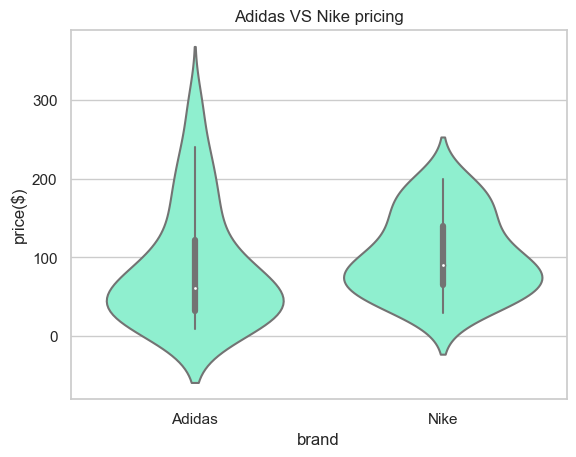

In [4]:
sns.set(style="whitegrid")
violin = sns.violinplot(x="brand", y="price", data=df_1,color="aquamarine")
# Add labels and a title
plt.xlabel("brand")
plt.ylabel("price($)")
plt.title("Adidas VS Nike pricing")
plt.show()

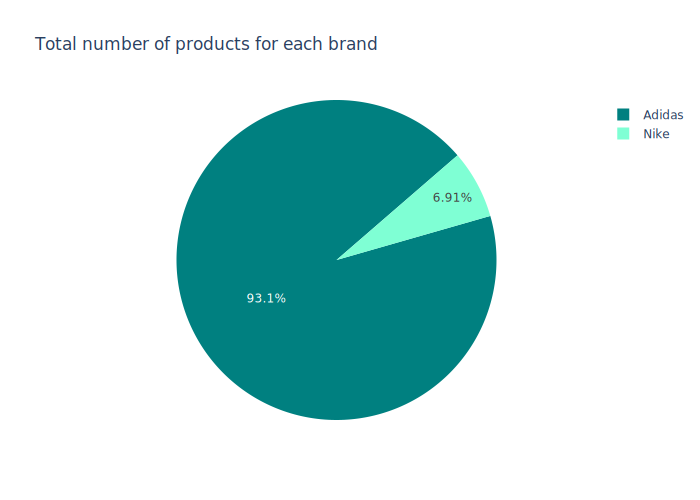

In [5]:
grouped_1 = df_1.groupby('brand')['num_products_price_category'].sum()
fig = px.pie(values=grouped_1.values, names=grouped_1.index, title='Total number of products for each brand',
            color=grouped_1.index, color_discrete_map={'Nike':'aquamarine',
                                 'Adidas':'teal'})
fig.update_traces(title_font_size= 18,selector=dict(type='pie'),rotation=74)
fig.show()

We can see that the average product prices is little higher in nike products, but addidas has much product variations than nike so it has some higher and lower prices based on the product.

In [6]:
sql_statement = """
WITH top_products AS(
SELECT B.brand,F.revenue,I.product_name
FROM brands B
INNER JOIN FINANCE F ON B.product_id = F.product_id
INNER JOIN info I ON B.product_id = I.product_id
WHERE b.brand IS NOT NULL)
SELECT TOP(5) brand, product_name,ROUND(SUM(revenue),0) AS total_revenue,
DENSE_RANK() OVER(ORDER BY SUM(revenue) DESC) AS rank
FROM top_products
WHERE brand = 'Adidas'
GROUP BY brand,product_name
UNION
SELECT DISTINCT TOP(5) brand, product_name,ROUND(SUM(revenue),0) AS total_revenue,
DENSE_RANK() OVER(ORDER BY SUM(revenue) DESC) AS rank
FROM top_products
WHERE brand = 'Nike'
GROUP BY brand,product_name
ORDER BY total_revenue DESC;  """
df_11 = pd.read_sql_query(sql_statement,engine)
df_11

,brand,product_name,total_revenue,rank
0,Adidas,Women's adidas Running Ultraboost 19 Shoes,149675.0,1
1,Adidas,WOMEN'S ADIDAS ORIGINALS NMD_R1 SHOES,126302.0,2
2,Adidas,Men's adidas Running Ultraboost 19 Shoes,119212.0,3
3,Adidas,Men's adidas Originals Stan Smith Shoes,114427.0,4
4,Adidas,Men's adidas Originals ZX 4000 4D Shoes,105044.0,5
5,Nike,Nike Epic React Flyknit 2,21896.0,1
6,Nike,Nike Air Max 720,17391.0,2
7,Nike,Nike Air Max 270 React,8842.0,3
8,Nike,Nike Air VaporMax 2019,7429.0,4
9,Nike,Nike Air Force 1 GORE-TEX ®,6316.0,5


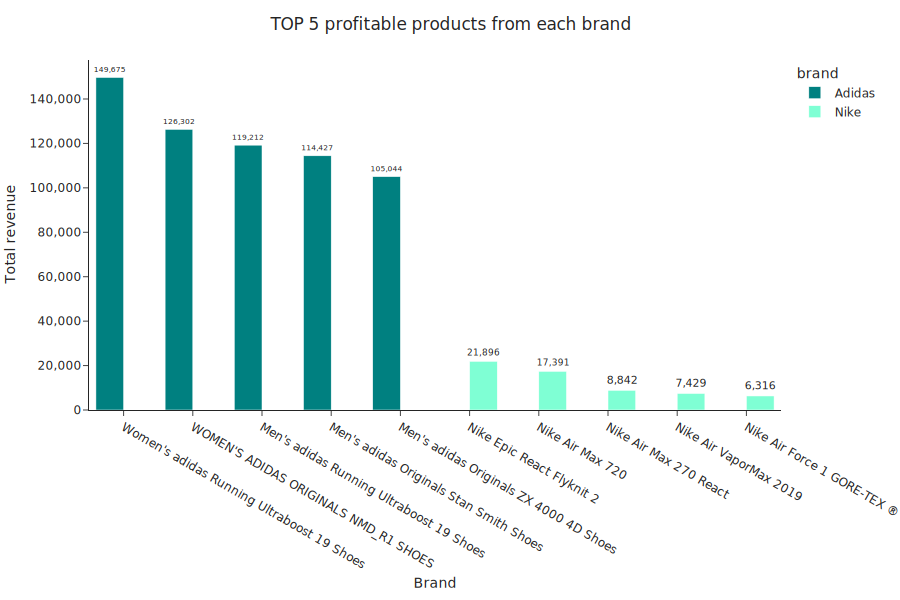

In [7]:
fig = px.bar(df_11,x='product_name',y='total_revenue',color="brand",barmode='group',width=900, height=600,
         template="simple_white",text_auto=True,color_discrete_map={
        'Adidas': 'teal',
        'Nike': 'aquamarine',
        'Average':'aqua',
        'Budget':'teal'})
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_tickformat = ',',title_text='TOP 5 profitable products from each brand', title_x=0.5)
fig.update_xaxes(title_text="Brand")
fig.update_yaxes(title_text="Total revenue")
fig.show()

In [8]:
sql_statement = """
WITH top_products AS(
SELECT B.brand,F.revenue,I.product_name
FROM brands B
INNER JOIN FINANCE F ON B.product_id = F.product_id
INNER JOIN info I ON B.product_id = I.product_id
WHERE b.brand IS NOT NULL)
SELECT brand, product_name,ROUND(SUM(revenue),0) AS total_revenue,
DENSE_RANK() OVER(ORDER BY SUM(revenue) DESC) AS rank
FROM top_products
GROUP BY brand,product_name;"""
df_12 = pd.read_sql_query(sql_statement,engine)
df_12[df_12['brand']=='Nike'][0:5]

,brand,product_name,total_revenue,rank
125,Nike,Nike Epic React Flyknit 2,21896.0,126
177,Nike,Nike Air Max 720,17391.0,178
413,Nike,Nike Air Max 270 React,8842.0,412
481,Nike,Nike Air VaporMax 2019,7429.0,479
540,Nike,Nike Air Force 1 GORE-TEX ®,6316.0,535


In [9]:
df_12.describe()

,total_revenue,rank
count,1159.000000,1159.000000
mean,10124.169111,569.239862
std,14596.539072,323.993069
min,0.000000,1.000000
25%,2160.500000,288.500000
50%,5636.000000,573.000000
75%,12111.000000,854.500000
max,149675.000000,1077.000000


As you can see from the previous query the first nike product appear in the ranking has rank 126 out of 1077 total

we can say that products that has total revenue of 5700 $ or above is considerd as an acceptable revenue. 

# Price segmentation

In [10]:
#Labeling price ranges
sql_statement = """
WITH CTE_price_category AS(
SELECT B.brand,F.product_id,F.revenue,
CASE WHEN listing_price < 42 THEN 'Budget'
WHEN listing_price BETWEEN 42 AND 73 THEN 'Average'
WHEN listing_price BETWEEN 74 AND 128 THEN 'Expensive'
ELSE 'Elite'
END AS price_category
FROM brands B INNER JOIN FINANCE F ON B.product_id = F.product_id
WHERE b.brand IS NOT NULL)
SELECT brand,COUNT(product_id) AS num_products_price_category, ROUND(SUM(revenue),0) AS total_revenue,price_category, ROUND(SUM(revenue)/COUNT(product_id),0) AS average_revenue
FROM CTE_price_category
GROUP BY brand, price_category
ORDER BY average_revenue DESC; """
df_2 = pd.read_sql_query(sql_statement,engine)
df_2

,brand,num_products_price_category,total_revenue,price_category,average_revenue
0,Adidas,307,3014317.0,Elite,9819.0
1,Adidas,849,4626980.0,Expensive,5450.0
2,Adidas,1060,3233661.0,Average,3051.0
3,Adidas,359,651661.0,Budget,1815.0
4,Nike,82,128476.0,Elite,1567.0
5,Nike,90,71843.0,Expensive,798.0
6,Nike,16,6623.0,Average,414.0
7,Nike,3,345.0,Budget,115.0


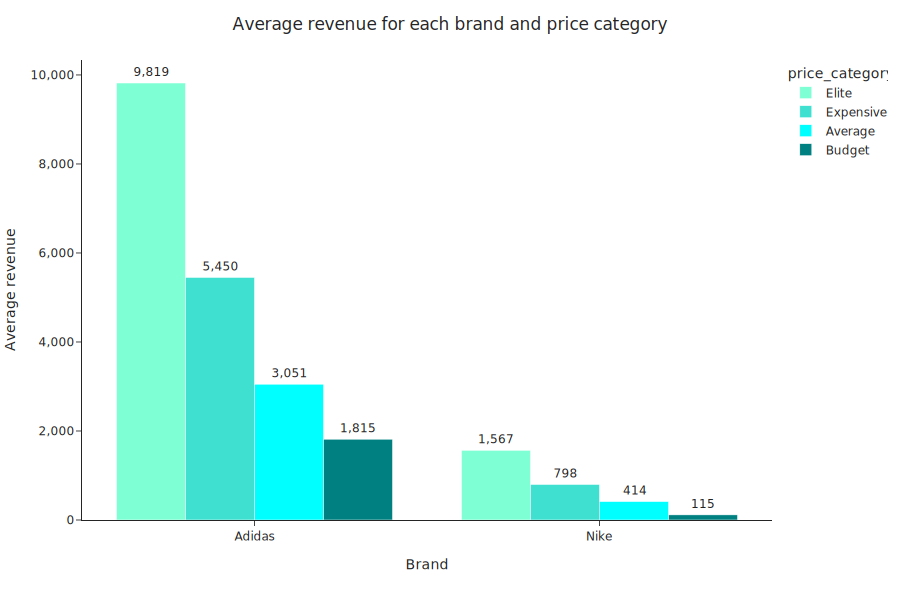

In [11]:
fig = px.bar(df_2,x='brand',y='average_revenue',color="price_category",barmode='group',width=900, height=600,
            color_discrete_map={
        'Elite': 'aquamarine',
        'Expensive': 'turquoise',
        'Average':'aqua',
        'Budget':'teal'},template="simple_white",text_auto=True)
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_tickformat = ',',title_text='Average revenue for each brand and price category', title_x=0.5)
fig.update_xaxes(title_text="Brand")
fig.update_yaxes(title_text="Average revenue")
fig.show()

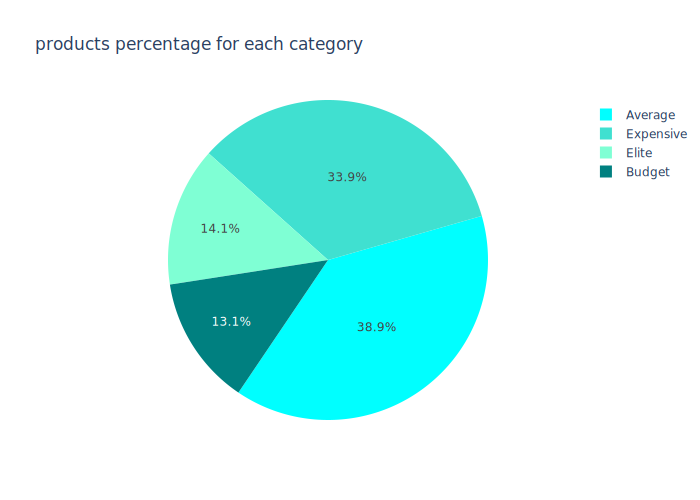

In [12]:
fig = px.pie(values=df_2['num_products_price_category'], names= df_2['price_category'],
             title='products percentage for each category',
            color=df_2['price_category'], color_discrete_map={
        'Elite': 'aquamarine',
        'Expensive': 'turquoise',
        'Average':'aqua',
        'Budget':'teal'})
fig.update_traces(title_font_size= 18,selector=dict(type='pie'),rotation=74)
fig.show()

Interestingly, grouping products by brand and price range allows us to see that Adidas items generate more total revenue regardless of price category! Specifically, "Elite" Adidas products priced $129 or more typically generate the highest revenue,
and for Nike products there is any category can be compared to addidas products.

so the company can potentially increase revenue by:

1- shifting their stock to have a larger proportion of Adidas products priced $129 or more"Elite products".


2- get rid of all of nike products except for products that have total revenue of 5700$ or above, creating space for more Adidas items wchich can increase revenue.

In [13]:
#Average discount per brand
sql_statement = """
SELECT B.brand, AVG(F.discount)*100AS average_discount
FROM finance F INNER JOIN brands B ON B.product_id = F.product_id
GROUP BY brand
HAVING brand IS NOT NULL;"""
df_3 = pd.read_sql_query(sql_statement,engine)
df_3

,brand,average_discount
0,Nike,0.000000
1,Adidas,33.452427


Strangely, no discount is offered on Nike products! In comparison, not only do Adidas products generate the most revenue, but these products are also heavily discounted!

To improve revenue further, the company could try to reduce the amount of discount offered on Adidas products, and monitor sales volume to see if it remains stable. Alternatively, it could try offering a small discount on Nike products. This would reduce average revenue for these products, but may increase revenue overall if there is an increase in the volume of Nike products sold.

In [14]:
#Ratings and reviews by product description length
sql_statement ='''
SELECT ROUND(LEN(i.description), -2) AS description_length,
ROUND(AVG(r.rating), 2) AS average_rating
FROM info AS i
INNER JOIN reviews AS r 
ON i.product_id = r.product_id
WHERE i.description IS NOT NULL
GROUP BY ROUND(LEN(i.description), -2)
ORDER BY description_length;'''
df_5 = pd.read_sql_query(sql_statement,engine)
df_5

,description_length,average_rating
0,0,1.50
1,100,3.22
2,200,3.22
3,300,3.30
4,400,3.32
5,500,3.29
6,600,3.39
7,700,3.82


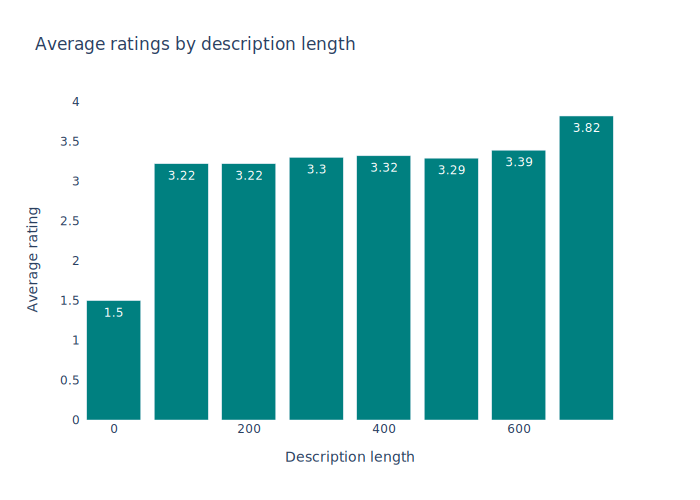

In [15]:
# Create a bar chart
fig = go.Figure(data=[go.Bar(x=df_5['description_length'], y=df_5['average_rating'],
                             marker=dict(color='teal'),text= df_5['average_rating'],textposition='auto')])

# Customize the layout
fig.update_layout(
    title="Average ratings by description length",
    xaxis_title="Description length",
    yaxis_title="Average rating",
    plot_bgcolor='white')
fig.show()

Unfortunately, there doesn't appear to be a clear pattern between the length of a product's description and its rating, but we should use describtions with at least 100:200 character it seems to be better for users ratings any more detailed describtions  doesn't have that big difference.

# bivariate analysis

In [16]:
#for bivariate analysis
sql_statement = """
SELECT DISTINCT B.product_id,B.brand,R.reviews ,F.revenue , R.rating AS ratings, F.discount ,F.listing_price
FROM reviews R 
INNER JOIN finance F ON F.product_id = R.product_id
INNER JOIN brands B ON B.product_id = R.product_id
WHERE R.reviews IS NOT NULL AND F.revenue IS NOT NULL AND R.rating IS NOT NULL AND brand IS NOT NULL; """
df_4 = pd.read_sql_query(sql_statement,engine)
total_revenue= df_4['revenue'].sum()
df_4

,product_id,brand,reviews,revenue,ratings,discount,listing_price
0,280648,Adidas,54.0,2915.030029,4.2,0.0,29.990000
1,288022,Adidas,95.0,5128.290039,3.3,0.0,29.990000
2,313358-006,Nike,4.0,806.179993,4.8,0.0,159.949997
3,325213-139,Nike,5.0,683.729980,3.6,0.0,94.949997
4,366731-100,Nike,4.0,454.820007,3.8,0.0,78.949997
...,...,...,...,...,...,...,...
2761,S75104,Adidas,70.0,6701.939941,4.9,0.3,75.989998
2762,S78048,Adidas,13.0,385.869995,4.1,0.5,32.990002
2763,S80662,Adidas,28.0,1209.599976,2.0,0.6,59.990002
2764,S80807,Adidas,43.0,2476.800049,4.2,0.6,79.989998


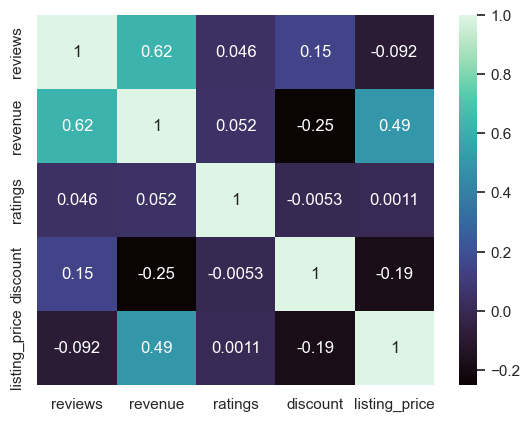

In [17]:
df_44 = df_4[['reviews','revenue','ratings','discount','listing_price']]
df_44
sns.heatmap(df_44.corr(), cmap="mako", annot=True)
plt.show()

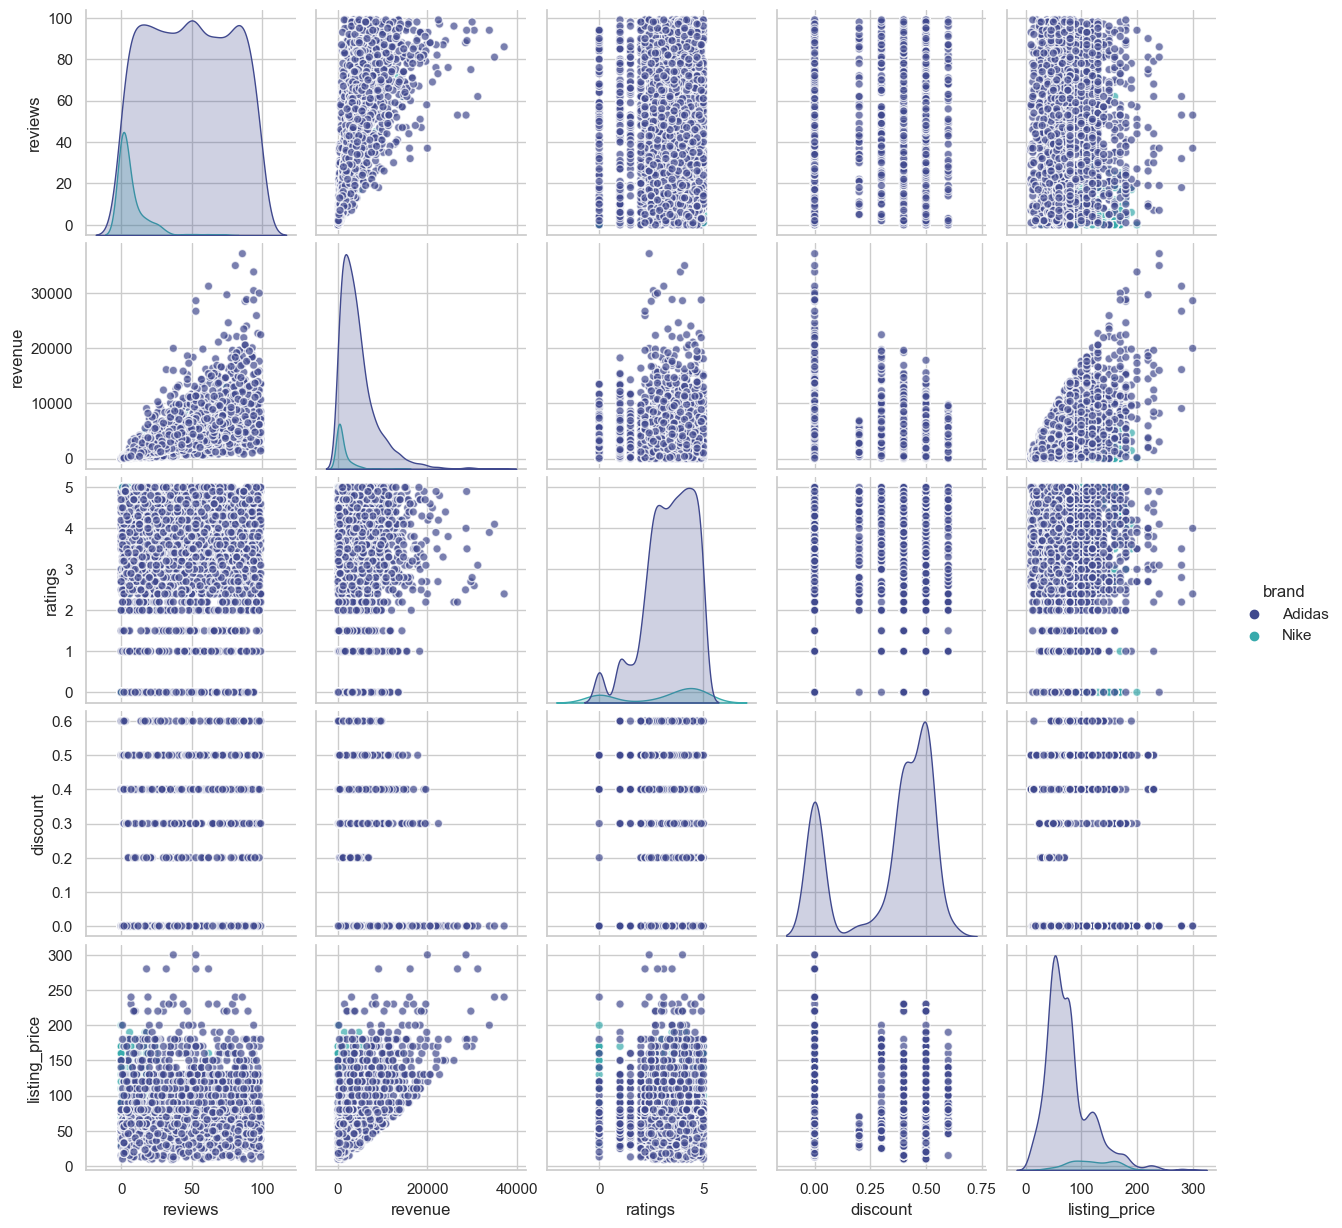

In [18]:
sns.pairplot(data = df_4,plot_kws=dict(marker="o", linewidth=1,alpha=0.7),hue='brand',diag_kws=dict(fill=True),palette='mako')
plt.show()

Interestingly, there is a strong positive correlation between revenue and reviews. 

That means if we can get more reviews on the company's website, it may increase sales of those items with a larger number of reviews.

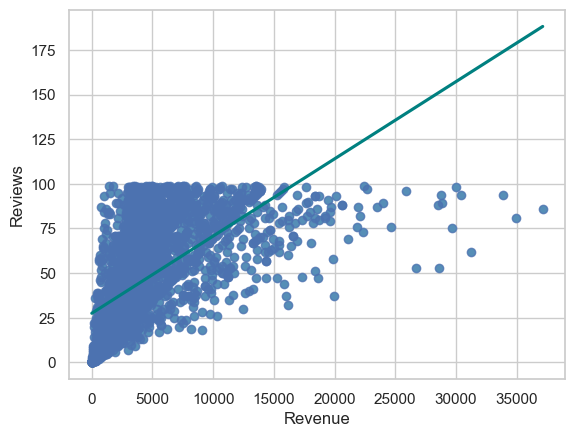

In [19]:
sns.scatterplot(x=df_4['revenue'], y=df_4['reviews'],alpha= 1,color='aquamarine')

# Add a correlation line
sns.regplot(data = df_4,x=df_4['revenue'], y= df_4['reviews'], ci=None, line_kws={"color": "teal"})

# Label the axes
plt.xlabel("Revenue")
plt.ylabel("Reviews")

# Show the plot
plt.show()

# Time series analysis

In [20]:
sql_statement ='''
SELECT B.brand, DATEPART(month, T.last_visited) AS month,
COUNT(R.product_id) AS num_reviews, ROUND(SUM(F.revenue), 0) AS total_revenue,Round(AVG(F.discount)*100,2) AS average_monthly_discount 
FROM brands B JOIN traffic T ON B.product_id = T.product_id
                JOIN reviews R ON B.product_id = R.product_id
                JOIN finance F ON B.product_id = F.product_id
GROUP BY brand, DATEPART(month, T.last_visited)
HAVING (brand IS NOT NULL) AND (DATEPART(month, t.last_visited) IS NOT NULL)
ORDER BY brand, month'''
df_6 = pd.read_sql_query(sql_statement,engine)
df_6

,brand,month,num_reviews,total_revenue,average_monthly_discount
0,Adidas,1,253,1085802.0,32.81
1,Adidas,2,272,1153606.0,34.63
2,Adidas,3,269,1160077.0,34.91
3,Adidas,4,180,854969.0,35.33
4,Adidas,5,172,708602.0,32.73
5,Adidas,6,159,727417.0,34.72
6,Adidas,7,170,779534.0,34.18
7,Adidas,8,189,889347.0,32.65
8,Adidas,9,181,879667.0,30.55
9,Adidas,10,192,908125.0,33.59


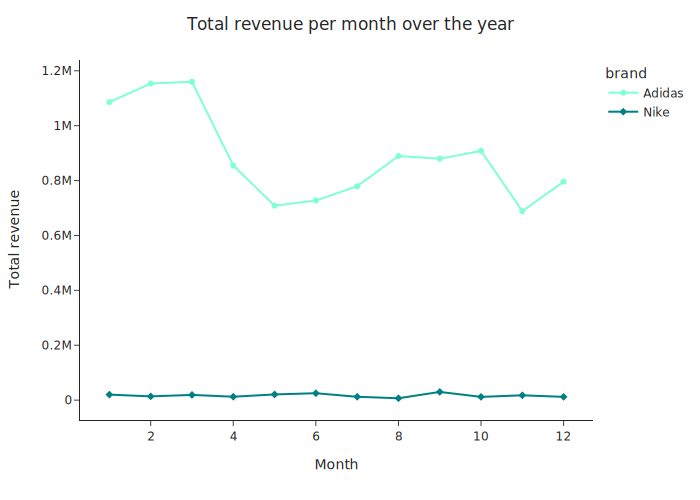

In [21]:
fig = px.line(df_6, x='month', y='total_revenue', color='brand', symbol="brand",
              color_discrete_map={
        'Adidas': 'aquamarine',
        'Nike': 'teal'},template="simple_white")
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Total revenue")
fig.update_layout(title_text='Total revenue per month over the year', title_x=0.5)
fig.update_traces(textposition="bottom right")
fig.show()

Revenues are highest in the first quarter of the calendar year then it goes down for the rest of the year,


is there anything special for the first quarter of the year? like offers or anything like that? lets see the effect of disscount on revenue

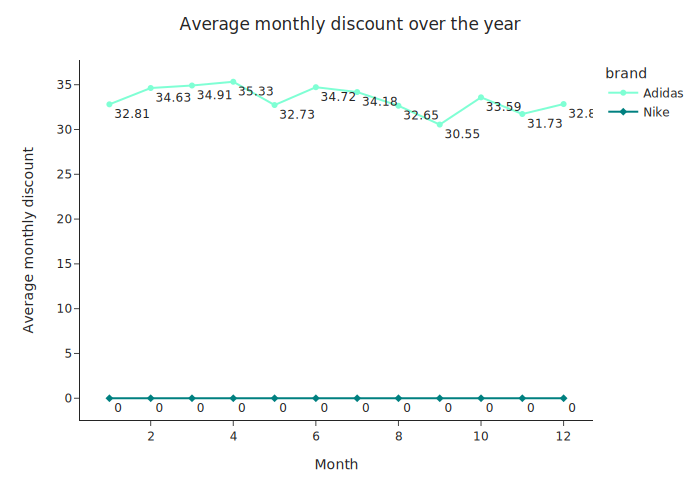

In [22]:
#Create a layout for the line chart
fig = px.line(df_6, x='month', y='average_monthly_discount', color='brand', symbol="brand",
              color_discrete_map={
        'Adidas': 'aquamarine',
        'Nike': 'teal'},template="simple_white",text="average_monthly_discount")
# position text on the chart
fig.update_traces(textposition="bottom right")
# Add titles to x-axis and y-axis
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Average monthly discount")
# Set the plot title
fig.update_layout(title_text='Average monthly discount over the year', title_x=0.5,yaxis_tickformat = '')
fig.show()

it seems like discount is almost the same for the whole year and it has no effect on revenue.

The company must run an experiment to discover what makes the first quarter of the year has the best revenue and focus on the results to make use of it for the rest of the year.

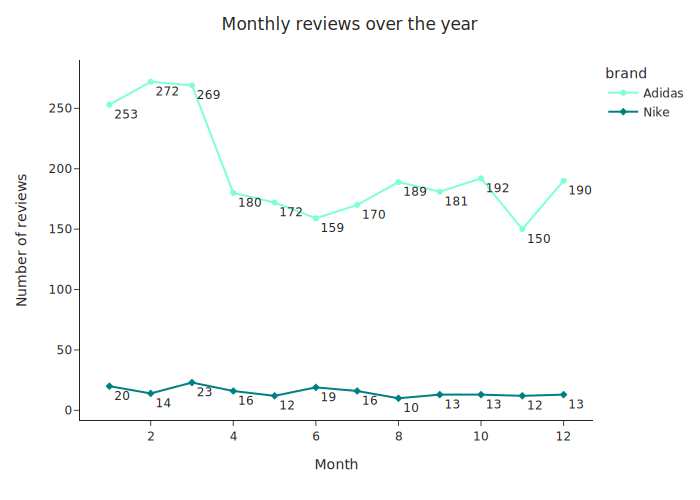

In [23]:
# Create a layout for the line chart
fig = px.line(df_6, x='month', y='num_reviews', color='brand', symbol="brand",
              color_discrete_map={
        'Adidas': 'aquamarine',
        'Nike': 'teal'},template="simple_white",text="num_reviews")
# position text on the chart
fig.update_traces(textposition="bottom right")
# Add titles to x-axis and y-axis
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Number of reviews")
# Set the plot title
fig.update_layout(title_text='Monthly reviews over the year', title_x=0.5)
fig.show()

Looks like product reviews are highest in the first quarter of the calendar year, so there is scope to run experiments aiming to increase the volume of reviews in the other nine months!

# product segmentation analysis

In [24]:
#Footwear product performance
sql_statement ='''
WITH footwear AS
(
    SELECT i.description, Round(f.revenue,0) as revenue,R.reviews,R.rating
    FROM info AS i
    INNER JOIN finance AS f 
        ON i.product_id = f.product_id
    INNER JOIN reviews  AS R
        ON R.product_id = f.product_id
    WHERE i.description LIKE '%shoe%'
        OR i.description LIKE '%trainer%'
        OR i.description LIKE '%foot%'
        AND i.description IS NOT NULL
)
SELECT * FROM footwear
'''
df_8 = pd.read_sql_query(sql_statement,engine)
df_8.describe()

,revenue,reviews,rating
count,2547.000000,2547.000000,2547.000000
mean,4404.718885,47.568512,3.346643
std,4307.475650,29.396889,1.204707
min,0.000000,0.000000,0.000000
25%,1494.500000,22.000000,2.700000
50%,3284.000000,48.000000,3.500000
75%,5723.000000,73.000000,4.300000
max,37150.000000,99.000000,5.000000


In [25]:
footwear_revenue = df_8['revenue'].sum() / total_revenue
footwear_revenue

0.9561026420982535

We found there are 2766 products without missing values for description. Of those, 2,547 are footwear products, which accounts for around 92% of the company's stock. They also generate a median revenue of over $3000 dollars! and they generate 95% of the total revenue.
This is interesting, but we have no point of reference for whether footwear's median_revenue is good or bad compared to other products. So, for our final task, let's examine how this differs to clothing products. We will re-use footwear, adding a filter afterward to count the number of products and median_revenue of products that are not in footwear.




In [26]:
#Clothing product performance
sql_statement ='''
WITH clothwear AS
(
    SELECT i.description, f.revenue, R.reviews,R.rating
    FROM info AS i
    INNER JOIN finance AS f 
        ON i.product_id = f.product_id
    INNER JOIN reviews  AS R
        ON R.product_id = f.product_id
    WHERE i.description NOT LIKE '%shoe%'
        AND i.description NOT LIKE '%trainer%'
        AND i.description NOT LIKE '%foot%'
        AND i.description IS NOT NULL
)
SELECT * FROM clothwear
'''
df_9 = pd.read_sql_query(sql_statement,engine)
df_9.describe()

,revenue,reviews,rating
count,219.000000,219.000000,219.000000
mean,2352.112735,26.164384,3.302740
std,3789.738977,29.509607,1.540699
min,0.000000,0.000000,0.000000
25%,230.350006,3.000000,2.600000
50%,911.429993,15.000000,3.700000
75%,2638.025024,39.500000,4.500000
max,26711.050781,99.000000,5.000000


In [27]:
clothwear_revenue = df_9['revenue'].sum() / total_revenue
clothwear_revenue

0.043899505196799346

Footwear products generate 95.6% of the total revenue and occupy 92% of company stock.

Clothing products generate 4.4% of total revenue but occupy 8% of company stock.

Recommendation: Make all the company stock of footwear products only.



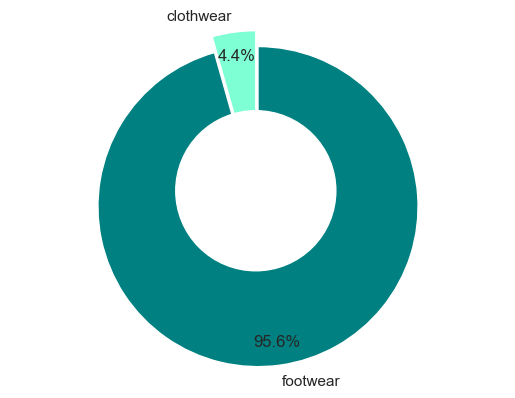

In [28]:
sizes = [clothwear_revenue, footwear_revenue]  # Sizes for the two "rings" of the donut chart
labels = ['clothwear', 'footwear']  # Labels for the two sections
colors = ['aquamarine', 'teal']  # Colors for the two sections
explode = (0, 0.1)  # Explode the second section 

# Create the outer pie chart (complete circle)
fig, ax = plt.subplots()
ax.pie([100], colors='white', radius=0.9)  # Creates a white circle at the center

# Create the inner pie chart (donut hole)
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
# Display the chart
plt.show()